<a href="https://colab.research.google.com/github/chuducthang77/Machine-Learning-tutorials-and-notes/blob/main/3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Overfitting problem

[0.29041806 0.7799726  0.7800932  1.87270059 2.99329242 3.00557506
 3.54036289 3.65996971 4.33088073 4.75357153]
[-0.85460612  1.69347735 -0.31828998  2.57554801  9.44372406  5.20692094
  9.08433372 12.27080321 16.73086565 23.22493698]
MSE for the first set of points: 0.00
MSE for the second set of points: 23887146.98


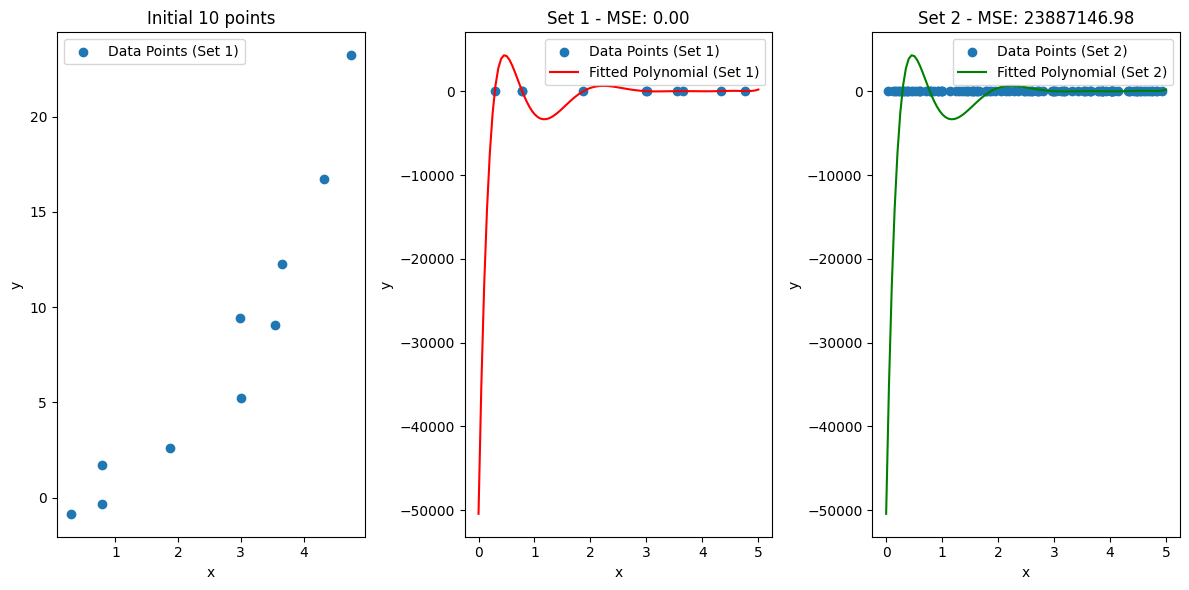

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Set a random seed for reproducibility
np.random.seed(42)

# Generate 10 random x values
x1 = np.sort(5 * np.random.rand(10))
# Generate corresponding y values with noise
y1 = x1**2 + 2 * np.random.randn(10)

# Generate another 100 random x values
x2 = np.sort(5 * np.random.rand(100))
# Generate corresponding y values with noise
y2 = x2**2 + 2 * np.random.randn(100)

# Reshape x values to 2D arrays (required by Scikit-Learn)
x1 = x1[:, np.newaxis]
x2 = x2[:, np.newaxis]

# Create polynomial features up to degree 9
poly_features = PolynomialFeatures(degree=9)

# Fit polynomial models to the first set of points
x1_poly = poly_features.fit_transform(x1)
model1 = LinearRegression()
model1.fit(x1_poly, y1)

# Fit polynomial models to the second set of points
x2_poly = poly_features.fit_transform(x2)

# Generate points along the fitted polynomial curves for visualization
x_fit1 = np.linspace(0, 5, 100)[:, np.newaxis]
x_fit1_poly = poly_features.transform(x_fit1)
y_fit1 = model1.predict(x_fit1_poly)

# Calculate Mean Squared Errors
mse1 = mean_squared_error(y1, model1.predict(x1_poly))
mse2 = mean_squared_error(np.hstack((y1, y2)), model1.predict(np.vstack((x1_poly, x2_poly))))

print(f'MSE for the first set of points: {mse1:.2f}')
print(f'MSE for the second set of points: {mse2:.2f}')

# Plot the two cases
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(x1, y1, label = 'Data Points (Set 1)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial 10 points')

plt.subplot(1, 3, 2)
plt.scatter(x1, y1, label='Data Points (Set 1)')
plt.plot(x_fit1, y_fit1, label='Fitted Polynomial (Set 1)', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title(f'Set 1 - MSE: {mse1:.2f}')

plt.subplot(1, 3, 3)
plt.scatter(np.vstack((x1, x2)), np.hstack((y1, y2)), label='Data Points (Set 2)')
plt.plot(x_fit1, y_fit1, label='Fitted Polynomial (Set 2)', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title(f'Set 2 - MSE: {mse2:.2f}')

plt.tight_layout()
plt.show()

# Problem 2: Convolution layer

- Assumption: 2d convolution, squared kernel, padding = (1,1), kernel is an odd number
- Input: Matrix (n $\times$ m), kernel = ($k_n, k_m$), padding = ($p_n, p_m$), stride = ($s_n, s_m$)
- Output: Matrix ($\lfloor\frac{n + 2 * p_n - k_n}{s_n}\rfloor + 1$ , $\lfloor\frac{m + 2 * p_m - k_m}{s_m}\rfloor + 1$)
- Padding: Matrix (n $\times$ m) becomes matrix ((n+2 * $p_n$) $\times$ (m+2 * $p_m$))

Remark: The below implementation is generalized.

In [ ]:
import numpy as np
from typing import List, Tuple, Union
import torch.nn.functional as F

def add_padding(matrix: np.ndarray,
                padding: Tuple[int, int]) -> np.ndarray:

    n, m = matrix.shape
    padding_n, padding_m = padding

    padded_matrix = np.zeros((n + padding_n * 2, m + padding_m * 2))
    padded_matrix[padding_n : n + padding_n, padding_m : m + padding_m] = matrix

    return padded_matrix


def conv2d(matrix: Union[List[List[float]], np.ndarray],
             kernel: Union[List[List[float]], np.ndarray],
             stride: Tuple[int, int] = (1, 1),
             padding: Tuple[int, int] = (0, 0)) -> np.ndarray:

    n, m = matrix.shape

    # Add padding if need
    if list(padding) != [0, 0]:
      matrix = add_padding(matrix, padding)
    k = kernel.shape

    # Determine the output dimension
    n_out = np.floor((n + 2 * padding[0] - k[0] ) / stride[0]).astype(int) + 1
    m_out = np.floor((m + 2 * padding[1] - k[1] ) / stride[1]).astype(int) + 1


    matrix_out = np.zeros((n_out, m_out))
    b = k[0] // 2, k[1] // 2
    for i in range(n_out):
        # print('For dimension x_', i)
        center_x = b[0] + i * stride[0]
        indices_x = [center_x + l for l in range(-b[0], b[0] + 1)]
        # print('center_x: ', center_x)
        # print('indices_x: ', indices_x)
        for j in range(m_out):
            # print('For dimension y_', j)
            center_y = b[1] + j * stride[1]
            indices_y = [center_y + l for l in range(-b[1], b[1] + 1)]
            # print('center_y: ', center_y)
            # print('indices_y: ', indices_y)
            submatrix = matrix[indices_x, :][:, indices_y]
            # print('submatrix: ',submatrix)
            matrix_out[i][j] = np.sum(np.multiply(submatrix, kernel))
    return matrix_out



matrix = np.array([[0, 4, 3, 2, 0, 1, 0],
                         [4, 3, 0, 1, 0, 1, 0],
                         [1, 3, 4, 2, 0, 1, 0],
                         [3, 4, 2, 2, 0, 1, 0],
                         [0, 0, 0, 0, 0, 1, 0]])

kernel = np.array([[1, 1, 3],
                    [0, 2, 3],
                    [3, 3, 3]])

# stride = 1, padding = 0
result_110 = conv2d(matrix, kernel)

# stride = 1,  padding = 1
result_111 = conv2d(matrix, kernel, padding=(1, 1))

# stride = 2, padding = 0
result_112 = conv2d(matrix, kernel, stride=(2,2))

# stride = 2, padding = 1
result_113 = conv2d(matrix, kernel, stride=(2,2), padding=(1,1))

print('Case 1')
print(result_110)
print(F.conv2d(torch.from_numpy(matrix).unsqueeze(0).unsqueeze(0), torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0)))

print('----------------------------------------------------------------')
print('Case 2')
print(result_111)
print(F.conv2d(torch.from_numpy(matrix).unsqueeze(0).unsqueeze(0), torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0), padding=1))

print('----------------------------------------------------------------')
print('Case 3')
print(result_112)
print(F.conv2d(torch.from_numpy(matrix).unsqueeze(0).unsqueeze(0), torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0), stride=2))

print('----------------------------------------------------------------')
print('Case 4')
print(result_113)
print(F.conv2d(torch.from_numpy(matrix).unsqueeze(0).unsqueeze(0), torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0), padding=1, stride=2))


Case 1
[[43. 43. 25. 17.  6.]
 [52. 44. 17. 16.  6.]
 [30. 23. 10. 11.  6.]]
tensor([[[[43, 43, 25, 17,  6],
          [52, 44, 17, 16,  6],
          [30, 23, 10, 11,  6]]]])
----------------------------------------------------------------
Case 2
[[33. 38. 24.  7.  9.  5.  3.]
 [41. 43. 43. 25. 17.  6.  4.]
 [45. 52. 44. 17. 16.  6.  4.]
 [28. 30. 23. 10. 11.  6.  4.]
 [15. 13. 12.  4.  8.  3.  1.]]
tensor([[[[33, 38, 24,  7,  9,  5,  3],
          [41, 43, 43, 25, 17,  6,  4],
          [45, 52, 44, 17, 16,  6,  4],
          [28, 30, 23, 10, 11,  6,  4],
          [15, 13, 12,  4,  8,  3,  1]]]])
----------------------------------------------------------------
Case 3
[[43. 25.  6.]
 [30. 10.  6.]]
tensor([[[[43, 25,  6],
          [30, 10,  6]]]])
----------------------------------------------------------------
Case 4
[[33. 24.  9.  3.]
 [45. 44. 16.  4.]
 [15. 12.  8.  1.]]
tensor([[[[33, 24,  9,  3],
          [45, 44, 16,  4],
          [15, 12,  8,  1]]]])


In [ ]:
matrix = np.array([[0, 4, 3, 2, 0, 1, 0, 3],
                         [4, 3, 0, 1, 0, 1, 0, 1],
                         [1, 3, 4, 2, 0, 1, 0, 2],
                         [3, 4, 2, 2, 0, 1, 0, 2],
                         [0, 0, 0, 0, 0, 1, 0, 4],
                   [0, 1, 1, 0, 3, 1, 0, 2]])
kernel = np.array([[1, 1, 3],
                    [0, 2, 3],
                    [3, 3, 3]
                   ])

print(conv2d(matrix, kernel))
print(F.conv2d(torch.from_numpy(matrix).unsqueeze(0).unsqueeze(0), torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0)))

[[43. 43. 25. 17.  6. 22.]
 [52. 44. 17. 16.  6. 19.]
 [30. 23. 10. 11.  6. 28.]
 [19. 18. 16. 20. 15. 28.]]
tensor([[[[43, 43, 25, 17,  6, 22],
          [52, 44, 17, 16,  6, 19],
          [30, 23, 10, 11,  6, 28],
          [19, 18, 16, 20, 15, 28]]]])


# Problem 3

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20] - Train Loss: 1.5764
Epoch [2/20] - Train Loss: 1.2030
Epoch [3/20] - Train Loss: 1.0285
Epoch [4/20] - Train Loss: 0.9218
Epoch [5/20] - Train Loss: 0.8487
Epoch [6/20] - Train Loss: 0.7943
Epoch [7/20] - Train Loss: 0.7558
Epoch [8/20] - Train Loss: 0.7202
Epoch [9/20] - Train Loss: 0.6884
Epoch [10/20] - Train Loss: 0.6702
Epoch [11/20] - Train Loss: 0.6431
Epoch [12/20] - Train Loss: 0.6266
Epoch [13/20] - Train Loss: 0.6111
Epoch [14/20] - Train Loss: 0.6032
Epoch [15/20] - Train Loss: 0.5892
Epoch [16/20] - Train Loss: 0.5669
Epoch [17/20] - Train Loss: 0.5573
Epoch [18/20] - Train Loss: 0.5458
Epoch [19/20] - Train Loss: 0.5407
Epoch [20/20] - Train Loss: 0.5276
Accuracy on the test set: 0.7915
Recall on the test set: 0.7915
F1-score on the test set: 0.7916


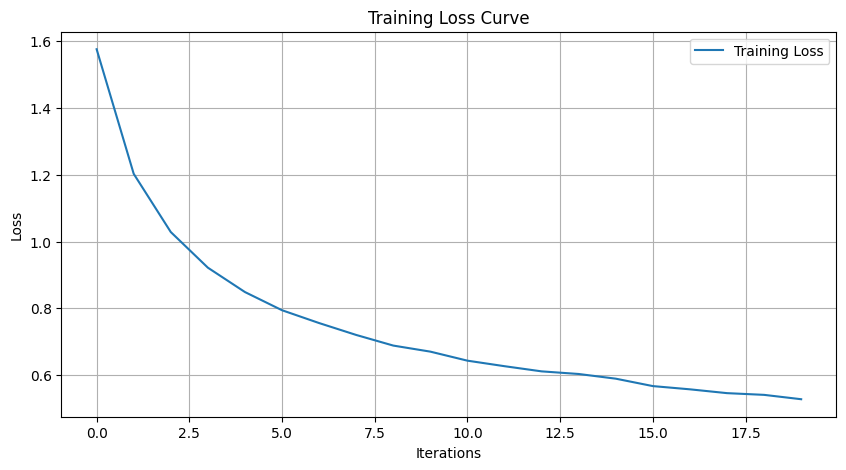

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define data preprocessing and loading
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the CNN architecture similar to VGG16
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model and define loss and optimizer
# Initialize the model and optimizer
model = VGG16()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

# Training loop
train_losses = []

for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # Predict the sample
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Update the parameter
        loss.backward()
        optimizer.step()

        # Keeping track the training loss
        training_loss += loss.item()
    train_loss = training_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch + 1}]: {train_loss:.4f}')


# Test the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Calculate accuracy, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy on the test set: {accuracy:.4f}')
print(f'Recall on the test set: {recall:.4f}')
print(f'F1-score on the test set: {f1:.4f}')


# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training Loss Curve')
plt.show()

# Problem 4

- Reduces height and width due to filter of the convolution layer
- Increases depth due to different channels represents different features and patterns. The more depth channels, the more detailed the features is.